In [9]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pickle
%matplotlib inline

In [3]:
# all data folders
all_folders = [folder for folder in os.listdir() if folder.startswith("varyamp_")]
all_folders

['varyamp_1560', 'varyamp_1558', 'varyamp_1559']

In [24]:
%%time
datafolder = "varyamp_1560/"
raw_data=[]
for file in os.listdir(datafolder)[:10]:
    data = ""
    with open(f"{datafolder}{file}","r") as f:
        data = f.readlines()
    raw_data.append( [int(d.split(",")[0]) for d in data[25:]] )
raw_data = np.array(raw_data)

CPU times: user 62.3 ms, sys: 7.98 ms, total: 70.3 ms
Wall time: 69.2 ms


In [25]:
header = data[:25]
header

['Format,1.0B,\n',
 'Memory Length,10000,Memory Length,10000,\n',
 'IntpDistance,0,IntpDistance,0,\n',
 'Trigger Address,4999,Trigger Address,4999,\n',
 'Trigger Level,1.040E+00,Trigger Level,1.040E+00,\n',
 'Source,CH1,Source,CH2,\n',
 'Vertical Units,V,Vertical Units,V,\n',
 'Vertical Units Div,0,Vertical Units Div,0,\n',
 'Vertical Units Extend Div,16,Vertical Units Extend Div,16,\n',
 'Label,,Label,,\n',
 'Probe Type,0,Probe Type,0,\n',
 'Probe Ratio,1.000e+01,Probe Ratio,1.000e+00,\n',
 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00,\n',
 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00,\n',
 'Horizontal Units,S,Horizontal Units,S,\n',
 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05,\n',
 'Horizontal Position,0.000E+00,Horizontal Position,0.000E+00,\n',
 'Horizontal Mode,Main,Horizontal Mode,Main,\n',
 'SincET Mode,Real Time,SincET Mode,Real Time,\n',
 'Sampling Period,2.000e-08,Sampling Period,2.000e-08,\n',
 'Horizontal Old Scale,2.000E-05,Horizontal Old Sca

In [26]:
scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
print(scope_settings)
trigger_level = float(data[4].split(",")[1])
vert_scale = float(data[12].split(",")[1])
vert_pos = float(data[13].split(",")[1])
trigger_level,vert_scale,vert_pos,np.max(raw_data),np.min(raw_data)

['Trigger Level,1.040E+00,Trigger Level,1.040E+00', 'Vertical Scale,5.000e-01,Vertical Scale,1.000e+00', 'Vertical Position,-1.820e+00,Vertical Position,0.000e+00', 'Horizontal Scale,2.000E-05,Horizontal Scale,2.000E-05', 'Sampling Period,2.000e-08,Sampling Period,2.000e-08']


(1.04, 0.5, -1.82, 100, -2)

In [12]:
%%time
tempdatafile = "proc_temp_data/read03_readdata.pkl"
raw_data_list = []
if not tempdatafile in os.listdir("proc_temp_data/"):
    for i,datafolder in enumerate(all_folders):
        raw_data1=[];raw_data2=[];
        for file in sorted(os.listdir(datafolder))[:-1]:
            data = ""
            with open(f"{datafolder}/{file}","r") as f:
                data = f.readlines()
            raw_data1.append( [int(d.split(",")[0]) for d in data[25:]])
            raw_data2.append( [int(d.split(",")[2]) for d in data[25:]]) 
        raw_data = np.array(raw_data1),np.array(raw_data2)
        raw_data_list.append( (datafolder,raw_data,data) )
    pickle.dump(raw_data_list,open(tempdatafile,"wb"))
else:
    raw_data_list = pickle.load(open(tempdatafile,"rb"))
print("done reading data")

done reading data
Wall time: 1min 45s


In [50]:
def get_scopesettings(data):
    scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
    trigger_level = float(data[4].split(",")[1])
    vert_scale = float(data[12].split(",")[1])
    vert_pos = float(data[13].split(",")[1])
    return scope_settings,trigger_level,vert_scale,vert_pos

In [58]:
led_data = []
apd_data = []
for i,_ in enumerate(all_folders[:-1]):
    datafolder, raw_data,data = raw_data_list[i]
    led_data.append(raw_data[1])
    apd_data.append(raw_data[0])
led_data = np.vstack(led_data)
apd_data = np.vstack(apd_data)

CPU times: user 11.5 s, sys: 1.85 s, total: 13.3 s
Wall time: 5.05 s


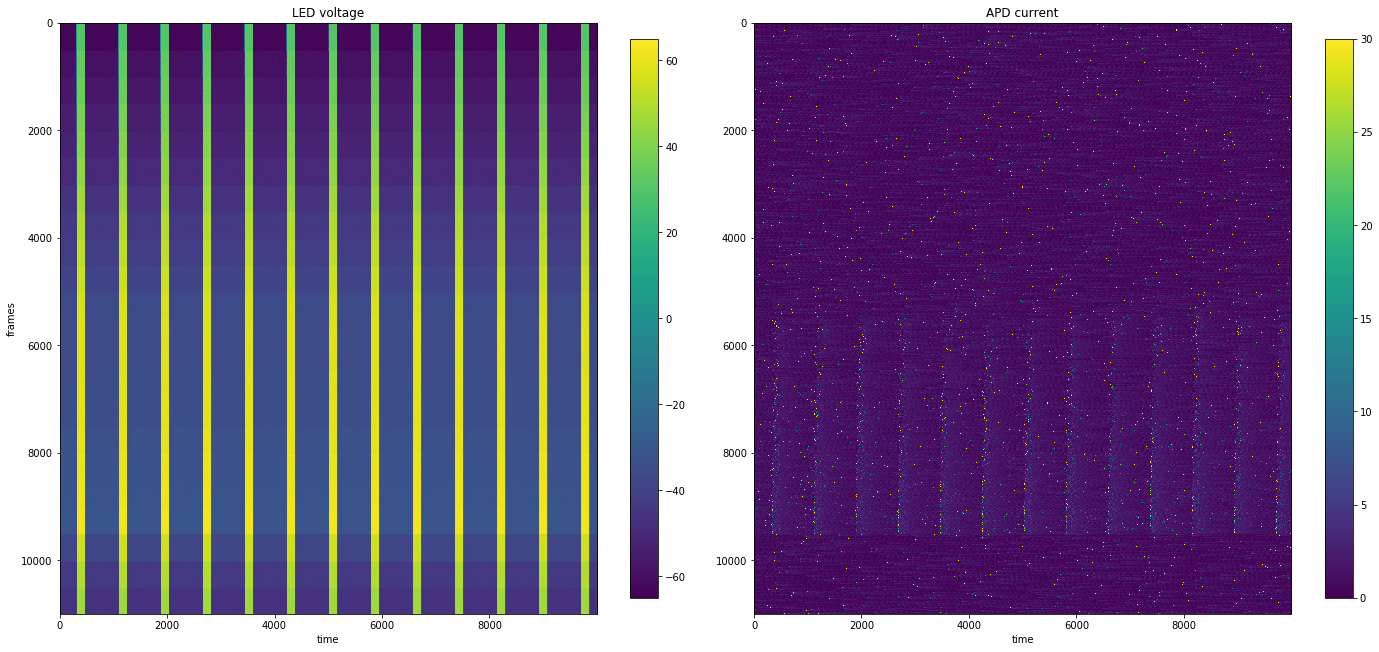

In [69]:
%%time
fig,axx = plt.subplots(1,2,figsize=(20,10))
ax=axx[0]
im=ax.imshow(led_data,interpolation=None)
plt.colorbar(im,ax=ax,shrink=0.8)
ax.set_title("LED voltage")
ax.set_xlabel("time")
ax.set_ylabel("frames")

ax=axx[1]
im=ax.imshow(np.clip(apd_data,0,30),interpolation=None)
plt.colorbar(im,ax=ax,shrink=0.8)
ax.set_title("APD current")
ax.set_xlabel("time")

plt.tight_layout()
plt.savefig("results03_ledvoltage.png",dpi=100)

Wall time: 43.1 s


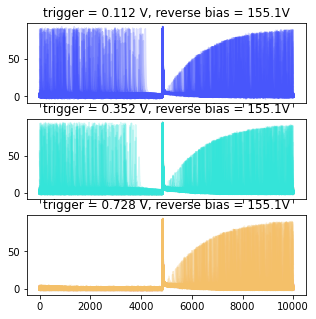

In [39]:
%%time
fig,axx = plt.subplots(3,1,sharex=True,figsize=(5,5))
for i,_ in enumerate(all_folders):
    ax=axx[i]
    datafolder, raw_data,data = raw_data_list[i]
    scope_settings,trigger_level,vert_scale,vert_pos = get_scopesettings(data)
    ax.plot(raw_data[:1000].T,c=plt.cm.rainbow(trigger_level),alpha=0.2)
    ax.set_title(f"trigger = {trigger_level} V, reverse bias = 155.1V")
plt.savefig("results02_triggerlevel.png")

### average time before each trigger

In [41]:
i=0
datafolder, raw_data,data = raw_data_list[i]
scope_settings,trigger_level,vert_scale,vert_pos = get_scopesettings(data)

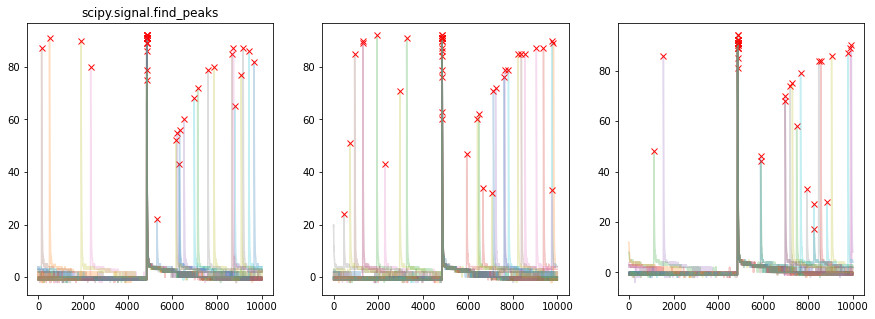

In [85]:
from scipy.signal import find_peaks

fig,axx = plt.subplots(1,3,figsize=(15,5))
for plot_i,ax in enumerate(axx):
    for i in range(60+plot_i*20,80+plot_i*20):
        peak_x , peak_heights = find_peaks(raw_data[i],height=10,width=10)
        ax.plot(raw_data[i],alpha=0.26)
        ax.plot(peak_x,peak_heights["peak_heights"],"x",c="r",alpha=0.96)
axx[0].set_title("scipy.signal.find_peaks")
plt.savefig("results02_peakfinding_success.png")

## todo, find the time intervals between peaks

notes:

multimeter readings 

1.6 1.4 micro amp

voltage +2.448 -1.258

generator:

1.855vpp

300mv offset